In [1]:
# Устанавливаем и подключаем фастбук
!pip install -Uqq fastbook
from fastbook import *

     |████████████████████████████████| 720 kB 28.9 MB/s 
     |████████████████████████████████| 189 kB 57.1 MB/s 
     |████████████████████████████████| 46 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 34.0 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 336 kB/s 


In [2]:
# Называем папки для датасета
tiger_types = 'South China', 'toy', 'white'
path = Path('tigers')

In [3]:
# Создаем датасет
if not path.exists():
    path.mkdir()
    for o in tiger_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} tiger', max_images = 100+100)
        download_images(dest, urls=results)

In [4]:
# Рразбиенем датасета на тренировочную и валидационную выборку
tigers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [5]:
# Указываем загрузчик данных
dls = tigers.dataloaders(path)

In [6]:
# Нарезаем картинки на квадраты
tigers = tigers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = tigers.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [9]:
# Обучаем модель (6 слоев)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.119716,0.172687,0.051282,02:04


epoch,train_loss,valid_loss,error_rate,time
0,0.239831,0.108816,0.025641,02:45
1,0.191467,0.041533,0.006410,02:45
2,0.159000,0.022719,0.012821,02:45
3,0.138282,0.026102,0.006410,02:45
4,0.112091,0.026661,0.006410,02:45
5,0.096202,0.027870,0.006410,02:46


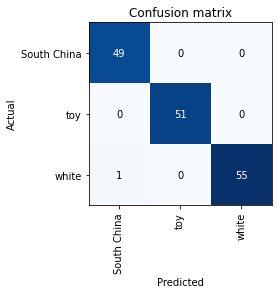

In [10]:
# Строим матрицу ошибок
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()